In [1]:
%pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Documents importants/Academic/MIT/Fall/15_572_Analytics_lab/Google Colab - ALab/Notebooks/src')

In [20]:
from utils import *
from nlp_utils import *

In [5]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

# automatically refresh imported modules
%reload_ext autoreload
%autoreload 2

## for data
import json
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, feature_selection
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api
from sklearn import metrics

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
path = '/content/drive/MyDrive/Documents importants/Academic/MIT/Fall/15_572_Analytics_lab/Google Colab - ALab/Data/ML_NOAC_NOVA_Extraction_Cleaned_DF3_Full.csv'
df = pd.read_csv(path)

var_used = "TeamName"
df["TeamName"] = df["TeamName"].str.replace("-", " ")
df.head()

In [9]:
lst_stopwords = nltk.corpus.stopwords.words("english")

df["text_clean"] = df[var_used].progress_apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

100%|██████████| 251234/251234 [00:13<00:00, 19250.31it/s]


In [10]:
## split dataset
df_train, df_test = model_selection.train_test_split(df, test_size=0.3)

## get target
y_train = df_train["Type"].values
y_test = df_test["Type"].values

# BAG OF WORDS

In [11]:
## Count (classic BoW)
vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))

## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

In [12]:
corpus = df_train["text_clean"]

vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [13]:
y = df_train["Type"]

X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()

for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))

    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])

    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
    
X_names = dtf_features["feature"].unique().tolist()


In [14]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(

dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")


# 0:
  . selected features: 364
  . top features: 3m,abinbev,adidas,anl exp,anl imp,auto,bkg,bkg auto,bkg elite,bkg exp
 
# 1:
  . selected features: 364
  . top features: 3m,abinbev,adidas,anl exp,anl imp,auto,bkg,bkg auto,bkg elite,bkg exp
 


In [15]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

# Naive Bayes Classifier

In [16]:
classifier = naive_bayes.MultinomialNB()
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])

## train classifier
model["classifier"].fit(X_train, y_train)

MultinomialNB()

Probability Threshold:  0.4924927679867334
Accuracy: 0.72
Auc: 0.76
Detail:
              precision    recall  f1-score   support

           0       0.72      0.96      0.82     51357
           1       0.70      0.21      0.33     24014

    accuracy                           0.72     75371
   macro avg       0.71      0.59      0.58     75371
weighted avg       0.72      0.72      0.67     75371



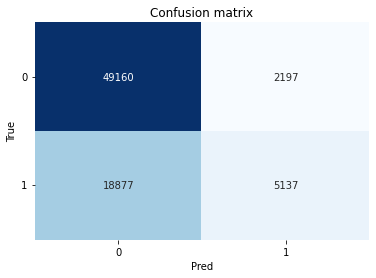

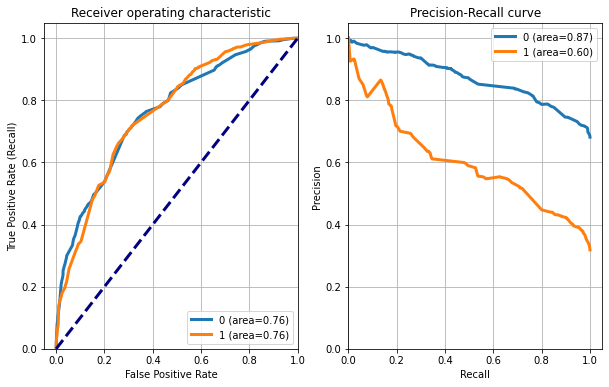

In [21]:
X_test = df_test["text_clean"].values
predicted_prob = model.predict_proba(X_test)
performance_report(y_test, predicted_prob, 0.7)

In [23]:
predicted = predicted_prob[:, 1] > 0.4924927679867334

## select observation
i = 3
txt_instance = df_test[var_used].iloc[i]
## check true value and predicted value
print("True:", y_test[i], "--> Pred:", predicted[i], "| Prob:", round(np.max(predicted_prob[i]),2))
## show explanation
explainer = lime_text.LimeTextExplainer(class_names=
             np.unique(y_train))
explained = explainer.explain_instance(txt_instance, 
             model.predict_proba, num_features=3)
explained.show_in_notebook(text=txt_instance, predict_proba=False)

True: 0 --> Pred: False | Prob: 0.62


# Random Forest Classifier

In [26]:
## pipeline
classifier = RandomForestClassifier()

model_rf = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])

## train classifier
model_rf["classifier"].fit(X_train, y_train)

Probability Threshold:  0.5735299877737462
Accuracy: 0.74
Auc: 0.79
Detail:
              precision    recall  f1-score   support

           0       0.74      0.95      0.83     51357
           1       0.73      0.28      0.40     24014

    accuracy                           0.74     75371
   macro avg       0.74      0.62      0.62     75371
weighted avg       0.74      0.74      0.70     75371



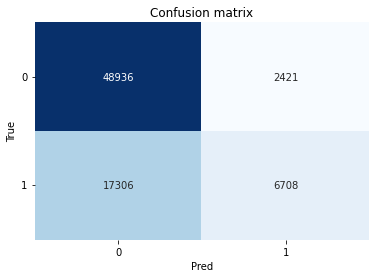

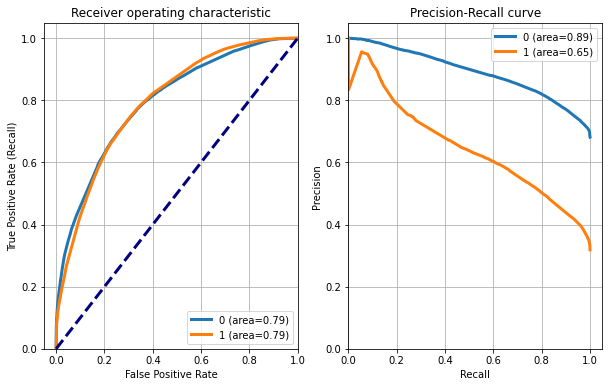

In [27]:
# make predictions
predicted_prob = model_rf.predict_proba(X_test)
performance_report(y_test, predicted_prob, 0.7)

In [ ]:
df.head()

In [34]:
X_test

array(['u cma bkg exp agriculture', 'u cma imp dedicated',
       'u bna cma bkg rfr mod', ..., 'u cma exp dedicated',
       'u cma bkg elite exxon', 'u cma cc cargo readiness'], dtype=object)

In [31]:
# EXPORT
train_preds = model_rf.predict_proba(X_train)[:, 1] > 0.5735299877737462
test_preds = model_rf.predict_proba(X_test)[:, 1] > 0.5735299877737462


AttributeError: ignored

In [30]:
export = df[['CaseNumber']]
export["Classifier__TeamName"] = 

,CaseNumber
0,100124562
1,100080371
2,100095395
3,100097054
4,100097055
...,...
251229,102470077
251230,102510003
251231,102509997
251232,102513703


# Gradient Boosting Classifier

In [24]:
## pipeline
classifier = GradientBoostingClassifier()

model_gb = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])

## train classifier
model_gb["classifier"].fit(X_train, y_train)

## test
X_test = df_test["text_clean"].values
predicted = model_gb.predict(X_test)
predicted_prob = model_gb.predict_proba(X_test)

Probability Threshold:  0.5592986433346603
Accuracy: 0.73
Auc: 0.78
Detail:
              precision    recall  f1-score   support

           0       0.73      0.97      0.83     51357
           1       0.76      0.22      0.34     24014

    accuracy                           0.73     75371
   macro avg       0.74      0.59      0.58     75371
weighted avg       0.74      0.73      0.67     75371



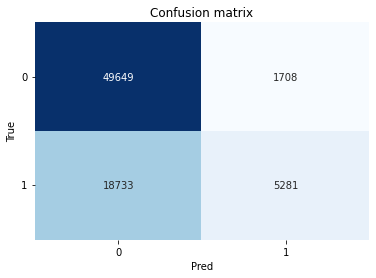

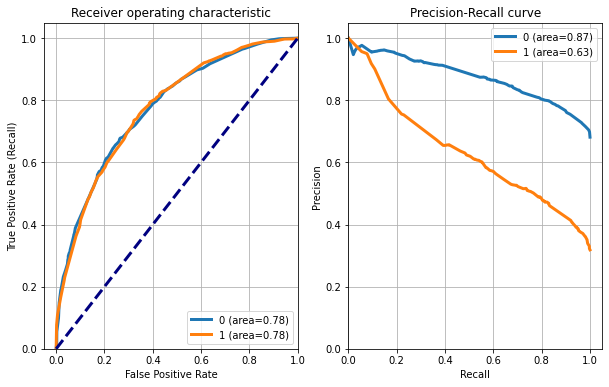

In [25]:
# make predictions
predicted_prob = model_gb.predict_proba(X_test)
performance_report(y_test, predicted_prob, 0.7)